- download demo files (train and set samples) : [here](https://drive.google.com/open?id=1Jf3BhC4R6VzR9ENLlt-rviQmEPuiqvHP)
- download model and logs here:[here](https://drive.google.com/open?id=1vNZXoaI_4IYrXMsAqFSIpXUyfL3mS5U0)

In [0]:
!unzip drive/My\ Drive/demo
!unrar e drive/My\ Drive/model_f

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [0]:
# generate training sample saliency videos
!mkdir demo/train/panorama
!mkdir demo/train/sal_panorama
!mkdir demo/train/gauss_panorama
!mkdir demo/train/gauss_flow_panorama
!mkdir demo/train/flow_panorama_t1
!mkdir demo/train/patched_flow_panorama
!mkdir demo/train/patched_sal_panorama
!mkdir demo/train/patched_panorama
for i in os.listdir('demo/train'):
  if os.path.isfile('demo/train/'+i):
    f = np.load('demo/train/'+i, allow_pickle=True)
    saliency = f['saliency']
    s = "{:03d}".format(int(i.split('_')[1]))+'.png'
    plt.imsave('demo/train/panorama/'+s, saliency[0])
    plt.imsave('demo/train/sal_panorama/'+s, saliency[1])
    plt.imsave('demo/train/gauss_panorama/'+s, saliency[2])
    plt.imsave('demo/train/gauss_flow_panorama/'+s, saliency[3])
    plt.imsave('demo/train/flow_panorama_t1/'+s, saliency[4])
    plt.imsave('demo/train/patched_flow_panorama/'+s, saliency[5])
    plt.imsave('demo/train/patched_sal_panorama/'+s, saliency[6])
    plt.imsave('demo/train/patched_panorama/'+s, saliency[7])

Convert generated frames of saliency into videos

In [0]:
!ffmpeg -framerate 5 -pattern_type glob -i 'demo/train/panorama/*.png' -c:v libx264 -r 30 -pix_fmt yuv420p panorama_train.mp4
!ffmpeg -framerate 5 -pattern_type glob -i 'demo/train/sal_panorama/*.png' -c:v libx264 -r 30 -pix_fmt yuv420p sal_panorama.mp4
!ffmpeg -framerate 5 -pattern_type glob -i 'demo/train/gauss_panorama/*.png' -c:v libx264 -r 30 -pix_fmt yuv420p gauss_panorama.mp4
!ffmpeg -framerate 5 -pattern_type glob -i 'demo/train/gauss_flow_panorama/*.png' -c:v libx264 -r 30 -pix_fmt yuv420p gauss_flow_panorama.mp4
!ffmpeg -framerate 5 -pattern_type glob -i 'demo/train/flow_panorama_t1/*.png' -c:v libx264 -r 30 -pix_fmt yuv420p flow_panorama_t1.mp4
!ffmpeg -framerate 5 -pattern_type glob -i 'demo/train/patched_flow_panorama/*.png' -c:v libx264 -r 30 -pix_fmt yuv420p patched_flow_panorama.mp4
!ffmpeg -framerate 5 -pattern_type glob -i 'demo/train/patched_sal_panorama/*.png' -c:v libx264 -r 30 -pix_fmt yuv420p patched_sal_panorama.mp4
!ffmpeg -framerate 5 -pattern_type glob -i 'demo/train/patched_panorama/*.png' -c:v libx264 -r 30 -pix_fmt yuv420p patched_panorama.mp4

Create the Data Generator to test the model on the test samples

In [0]:
import numpy as np
import keras
import os
			
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
		
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        saliency, trajectory_x, trajectory_y = self.__data_generation(list_IDs_temp)
        return [trajectory_x, saliency], trajectory_y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

			
	
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        saliency = np.empty((self.batch_size, 480*8, 960, 3))
        trajectory_x = np.empty((self.batch_size, 5, 2))
        trajectory_y = np.empty((self.batch_size, 2))
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample saliency
            current_frame = np.load(ID)
            saliency[i,] = np.concatenate(current_frame['saliency'], 0)
            trajectory_x[i,] = current_frame['trajectory_x']
            # Store trajectory prediction
            trajectory_y[i,] = current_frame['trajectory_y'][0]+current_frame['trajectory_x'][0] - current_frame['trajectory_x'][-1]
            current_frame.close()
            del current_frame
        return saliency, trajectory_x, trajectory_y

Create the model with the architecture to predict the gaze in the next 20 ms

In [0]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Lambda, concatenate, Reshape, Add
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras import backend as K


def global_network():
	"""
	The trajectory encoder module
	"""
	# Define an input sequence of previous gazes and process it.
	encoder_inputs = Input(shape=(5, 2))
	# Define the first lstm layer
	lstm1 = LSTM(128, return_sequences=True, return_state=True)
	# Define the second lstm layer
	lstm2 = LSTM(128)

	"""
	The Saliency encoder module
	"""
	# Define input for all spatial and temporal saliency maps and process it.
	saliency_inputs = Input(shape=(480*8, 960, 3))
	# get  Inception-ResNet-V2 to extract saliency features for gaze prediction followed with a global pooling
	inception = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(480*8, 960, 3), pooling='avg')
	for layer in inception.layers:
		layer.trainable = False
	# Two fully connected layer will be used to estimate the displacement
    # between the gaze point at time t + 1 and gaze point at time t
	dense_1 = Dense(1000)
	dense_2 = Dense(2)

	# apply the first lstm on the trajectory history of the 5 gazes
	lstm1_outputs, state_h, state_c = lstm1(encoder_inputs)
	lstm1_states = [state_h, state_c]
	# Set up the second lstm, using 'lstm1_states' as initial state.
	trajectory_encoder_outputs = lstm2(lstm1_outputs,initial_state=lstm1_states)
	# apply inception on the current saliency input
	current_saliency_inception = inception(saliency_inputs)
	"""
	Displacement Prediction Module
	"""
	# Concatenate s the output of saliency encoder module and trajectory encoder module
	merged = concatenate([current_saliency_inception, trajectory_encoder_outputs])
	# use two fully connected layer to estimate the displacement between the gaze point at time t + 1 and gaze point at time t
	dense_1000 = dense_1(merged)
	displacement_output = dense_2(dense_1000)
	# Create the proposed model
	model = Model([encoder_inputs, saliency_inputs], displacement_output)
	return model

Get the example from trainset

In [0]:
all_files = []
for frame in os.listdir('demo/train'):
  if os.path.isfile('demo/train/'+frame):
    all_files.append('demo/train/'+frame)

In [0]:
# build the data generator
train_generator = DataGenerator(all_files, 16)

Compile the model and load it with the learned weights

In [0]:
# build the model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping

network_model = global_network()
sgd = SGD(lr=0.01, decay=5e-4, momentum=0.9)
network_model.compile(optimizer=sgd, loss='mean_squared_error')
network_model.load_weights('model_all.hdf5')

Evaluate on the example from trainset

In [37]:
# start evaluation
loss = network_model.evaluate_generator(train_generator, verbose=1) 
print(loss)

6/6 [==============================] - 37s 6s/step
0.010379561533530554


Get the example from testset

In [0]:
all_files = []
for frame in os.listdir('demo/test'):
  if os.path.isfile('demo/test/'+frame):
    all_files.append('demo/test/'+frame)

In [0]:
# build the data generator
test_generator = DataGenerator(all_files, 16)

Evaluate on the example from testset

In [43]:
loss = network_model.evaluate_generator(test_generator, verbose=1) 
print(loss)

6/6 [==============================] - 40s 7s/step
0.03375694528222084


In [46]:
current_frame = np.load('demo/train/10_60_0.npz', allow_pickle=True)
saliency = np.concatenate(current_frame['saliency'], 0)
trajectory_x = current_frame['trajectory_x']
trajectory_y = current_frame['trajectory_y'][0]+current_frame['trajectory_x'][0] - current_frame['trajectory_x'][-1]
print("Real displacement position:", trajectory_y)
print("Predicted displacement position:", network_model.predict([[trajectory_x], [saliency]]))

Real displacement position: [0.0035442 0.000686 ]
Predicted displacement position: [[ 0.13163376 -0.00364902]]


Example of prediction on a certain frame ( red dot is for truthground and blue one for predicted)

truth ground [-0.0163958  0.0051773]
predicted [ 0.1299547  -0.01220817]
execution time= 0.43460893630981445 seconds


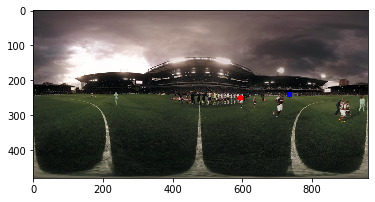

In [58]:
import time
f = np.load('demo/train/10_90_0.npz', allow_pickle=True)
a = f['saliency']
p = (a[0]*255).astype(np.int32)
pos_real = tuple(((f['trajectory_x'][0]+f['trajectory_y'][0])*[960, 480]).astype(int))
sal = np.concatenate(a, 0)
hist = f['trajectory_x']
s = time.time()
pred = network_model.predict([[hist], [sal]])
e = time.time()
pos_pred = tuple(((pred[0]+f['trajectory_x'][0])*[960, 480]).astype(int))
print("truth ground", f['trajectory_y'][0])
print("predicted", pred[0])
print("execution time=", e-s,"seconds")
output = cv2.circle(p, pos_real, 8, (255.,0.,0.), -1)
output = cv2.circle(output, pos_pred, 8, (0.,0.,255.), -1)
plt.imshow(output)

Loss function for both training and validation

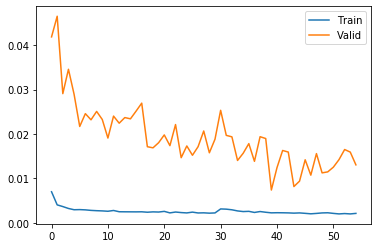

minimal valid loss= 0.007380146067589521


In [59]:
v0 = np.load('loss_log_0.npz')['valid']
v1 = np.load('loss_log_1.npz')['valid']
t0 = np.load('loss_log_0.npz')['loss']
t1 = np.load('loss_log_1.npz')['loss']
v = np.concatenate([v0, v1])
t = np.concatenate([t0, t1])
plt.plot(t, label='Train')
plt.plot(v, label='Valid')
plt.legend(loc='best')
plt.show()
print("minimal valid loss=", np.min(v))

Generate resulting video for train example that show positions of truthground(red) and predicted(blue) position

In [61]:
# training evaluation
!mkdir demo/train/result
for i in os.listdir('demo/train'):
  if os.path.isfile('demo/train/'+i):
    f = np.load('demo/train/'+i, allow_pickle=True)
    a = f['saliency']
    pos_real = tuple(((f['trajectory_x'][0]+f['trajectory_y'][0])*[960, 480]).astype(int))
    pred = network_model.predict([[f['trajectory_x']], [np.concatenate(a, 0)]])
    pos_pred = tuple(((pred[0]+f['trajectory_x'][0])*[960, 480]).astype(int))
    p = (a[0]*255).astype(np.int32)
    output = cv2.circle(p, pos_real, 8, (255,0,0), -1)
    output = cv2.circle(output, pos_pred, 8, (0,0,255), -1)
    s = "{:03d}".format(int(i.split('_')[1]))+'.png'
    cv2.imwrite('demo/train/result/'+s, output)

!ffmpeg -framerate 5 -pattern_type glob -i 'demo/train/result/*.png' -c:v libx264 -r 30 -pix_fmt yuv420p result_train.mp4

mkdir: cannot create directory ‘demo/train/result’: File exists
ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-

Generate resulting video for test example that show positions of truthground(red) and predicted(blue) position

In [0]:
# test evaluation
!mkdir demo/test/result
for i in os.listdir('demo/test'):
  if os.path.isfile('demo/test/'+i):
    f = np.load('demo/test/'+i, allow_pickle=True)
    a = f['saliency']
    pos_real = tuple(((f['trajectory_x'][0]+f['trajectory_y'][0])*[960, 480]).astype(int))
    pred = network_model.predict([[f['trajectory_x']], [np.concatenate(a, 0)]])
    pos_pred = tuple(((pred[0]+f['trajectory_x'][0])*[960, 480]).astype(int))
    p = (a[0]*255).astype(np.int32)
    output = cv2.circle(p, pos_real, 8, (255,0,0), -1)
    output = cv2.circle(output, pos_pred, 8, (0,0,255), -1)
    s = "{:03d}".format(int(i.split('_')[1]))+'.png'
    cv2.imwrite('demo/test/result/'+s, output)

!ffmpeg -framerate 5 -pattern_type glob -i 'demo/test/result/*.png' -c:v libx264 -r 30 -pix_fmt yuv420p result_test.mp4